# Detection with only the basic image operation (filter, Mophology, ...)

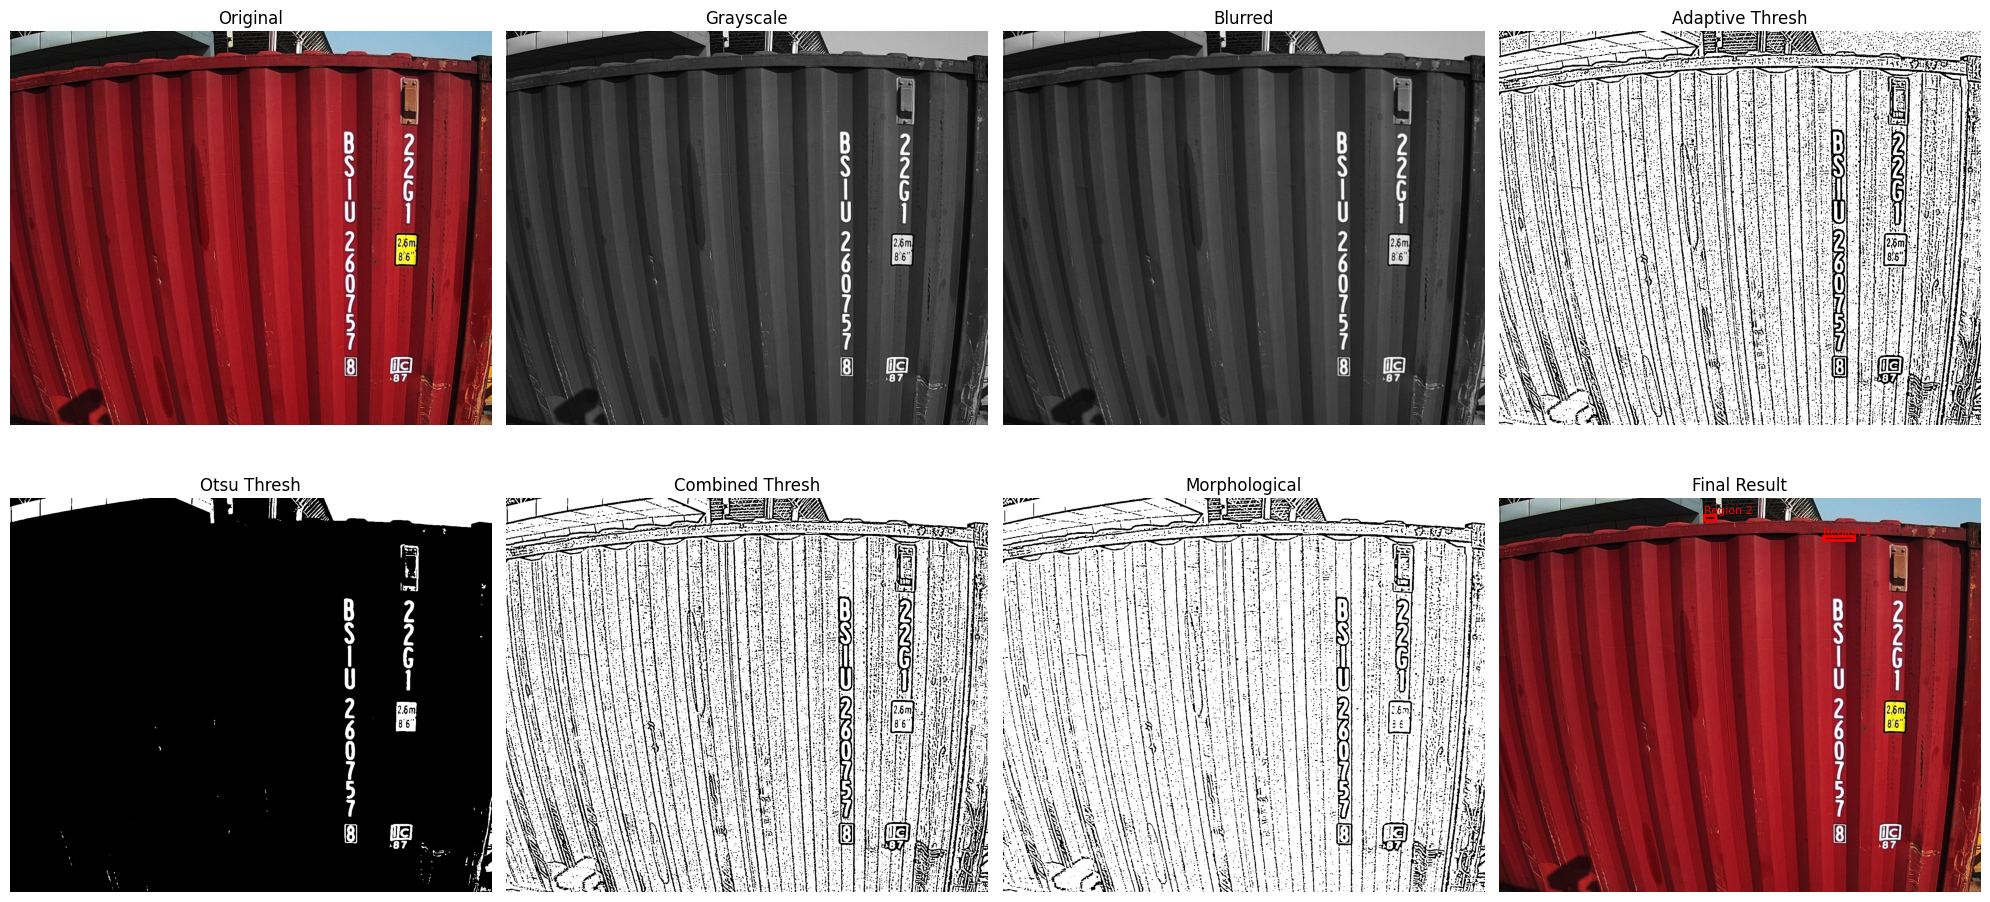

Detected 2 potential container code regions:
Region 1: Position=(887,105), Size=(85x11), Area=935, Aspect Ratio=7.73
Region 2: Position=(563,45), Size=(30x14), Area=420, Aspect Ratio=2.14

Extracted regions (ready for OCR):
Saved region 1 as 'container_code_region_1.jpg'
Saved region 2 as 'container_code_region_2.jpg'


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class ContainerCodeDetector:
    def __init__(self):
        self.debug_images = {}
    
    def preprocess_image(self, image):
        """Apply preprocessing to enhance text regions"""
        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        self.debug_images['original_gray'] = gray
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        self.debug_images['blurred'] = blurred
        
        return blurred
    
    def enhance_text_regions(self, image):
        """Enhance white text regions on dark background"""
        # Apply adaptive thresholding to handle varying lighting
        adaptive_thresh = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 15, 2
        )
        self.debug_images['adaptive_thresh'] = adaptive_thresh
        
        # Also try Otsu's thresholding
        _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        self.debug_images['otsu_thresh'] = otsu_thresh
        
        # Combine both thresholding methods
        combined_thresh = cv2.bitwise_or(adaptive_thresh, otsu_thresh)
        self.debug_images['combined_thresh'] = combined_thresh
        
        return combined_thresh
    
    def apply_morphological_operations(self, binary_image):
        """Apply morphological operations to clean up the image"""
        # Remove small noise with opening
        kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_small)
        self.debug_images['opened'] = opened
        
        # Connect nearby text characters with closing
        kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
        self.debug_images['closed'] = closed
        
        # Dilate to make text regions more prominent
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
        dilated = cv2.dilate(closed, kernel_dilate, iterations=1)
        self.debug_images['dilated'] = dilated
        
        return dilated
    
    def detect_text_regions(self, binary_image, original_image):
        """Detect potential text regions using contour analysis"""
        # Find contours
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours based on size and aspect ratio
        text_regions = []
        min_area = 100
        max_area = 5000
        min_aspect_ratio = 0.1
        max_aspect_ratio = 10
        
        for contour in contours:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            aspect_ratio = w / h if h > 0 else 0
            
            # Filter based on size and aspect ratio
            if (min_area < area < max_area and 
                min_aspect_ratio < aspect_ratio < max_aspect_ratio):
                
                # Additional filtering: check if region contains enough white pixels
                roi = binary_image[y:y+h, x:x+w]
                white_pixel_ratio = np.sum(roi == 255) / (w * h)
                
                if white_pixel_ratio > 0.1:  # At least 10% white pixels
                    text_regions.append({
                        'bbox': (x, y, w, h),
                        'area': area,
                        'aspect_ratio': aspect_ratio,
                        'white_ratio': white_pixel_ratio,
                        'roi': original_image[y:y+h, x:x+w] if len(original_image.shape) == 3 else original_image[y:y+h, x:x+w]
                    })
        
        # Sort by area (larger regions first, likely to be the main text)
        text_regions.sort(key=lambda x: x['area'], reverse=True)
        
        return text_regions
    
    def filter_container_code_regions(self, text_regions, image_shape):
        """Filter regions that are likely to contain container codes"""
        filtered_regions = []
        height, width = image_shape[:2]
        
        for region in text_regions:
            x, y, w, h = region['bbox']
            
            # Container codes are typically in the upper-right area of the container
            # and have specific characteristics
            
            # Position filtering (right half of image, upper portion)
            if x > width * 0.4 and y < height * 0.7:
                
                # Size filtering (not too small, not too large)
                if 20 < w < 200 and 10 < h < 50:
                    
                    # Aspect ratio filtering (text-like)
                    if 1 < region['aspect_ratio'] < 8:
                        filtered_regions.append(region)
        
        return filtered_regions
    
    def detect_codes(self, image_path):
        """Main function to detect container codes"""
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        self.debug_images['original'] = image
        
        # Preprocess
        preprocessed = self.preprocess_image(image)
        
        # Enhance text regions
        binary = self.enhance_text_regions(preprocessed)
        
        # Apply morphological operations
        cleaned = self.apply_morphological_operations(binary)
        
        # Detect text regions
        text_regions = self.detect_text_regions(cleaned, image)
        
        # Filter for container code regions
        code_regions = self.filter_container_code_regions(text_regions, image.shape)
        
        return code_regions
    
    def visualize_results(self, image_path, code_regions, show_debug=True):
        """Visualize the detection results"""
        image = cv2.imread(image_path)
        
        if show_debug:
            # Create a comprehensive visualization
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()
            
            # Show debug images
            debug_titles = ['Original', 'Grayscale', 'Blurred', 'Adaptive Thresh', 
                          'Otsu Thresh', 'Combined Thresh', 'Morphological', 'Final Result']
            debug_keys = ['original', 'original_gray', 'blurred', 'adaptive_thresh',
                         'otsu_thresh', 'combined_thresh', 'dilated', 'original']
            
            for i, (title, key) in enumerate(zip(debug_titles, debug_keys)):
                if i < 7:
                    img_to_show = self.debug_images.get(key, np.zeros((100, 100)))
                    if len(img_to_show.shape) == 3:
                        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(img_to_show, cmap='gray' if len(img_to_show.shape) == 2 else None)
                else:
                    # Show final result with bounding boxes
                    result_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(result_img)
                    
                    # Draw bounding boxes
                    for j, region in enumerate(code_regions):
                        x, y, w, h = region['bbox']
                        rect = Rectangle((x, y), w, h, linewidth=2, 
                                       edgecolor='red', facecolor='none')
                        axes[i].add_patch(rect)
                        axes[i].text(x, y-5, f'Region {j+1}', color='red', fontsize=8)
                
                axes[i].set_title(title)
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # Print region information
        print(f"Detected {len(code_regions)} potential container code regions:")
        for i, region in enumerate(code_regions):
            x, y, w, h = region['bbox']
            print(f"Region {i+1}: Position=({x},{y}), Size=({w}x{h}), "
                  f"Area={region['area']}, Aspect Ratio={region['aspect_ratio']:.2f}")
        
        return code_regions

# Example usage
def main():
    detector = ContainerCodeDetector()
    
    # Replace with your image path
    image_path = "cropped_container_simple.jpg"
    
    try:
        # Detect container codes
        code_regions = detector.detect_codes(image_path)
        
        # Visualize results
        detector.visualize_results(image_path, code_regions, show_debug=True)
        
        # Extract ROIs for each detected region (ready for OCR)
        print("\nExtracted regions (ready for OCR):")
        for i, region in enumerate(code_regions):
            roi = region['roi']
            # Save or process each ROI
            #cv2.imwrite(f'container_code_region_{i+1}.jpg', roi)
            print(f"Saved region {i+1} as 'container_code_region_{i+1}.jpg'")
            
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

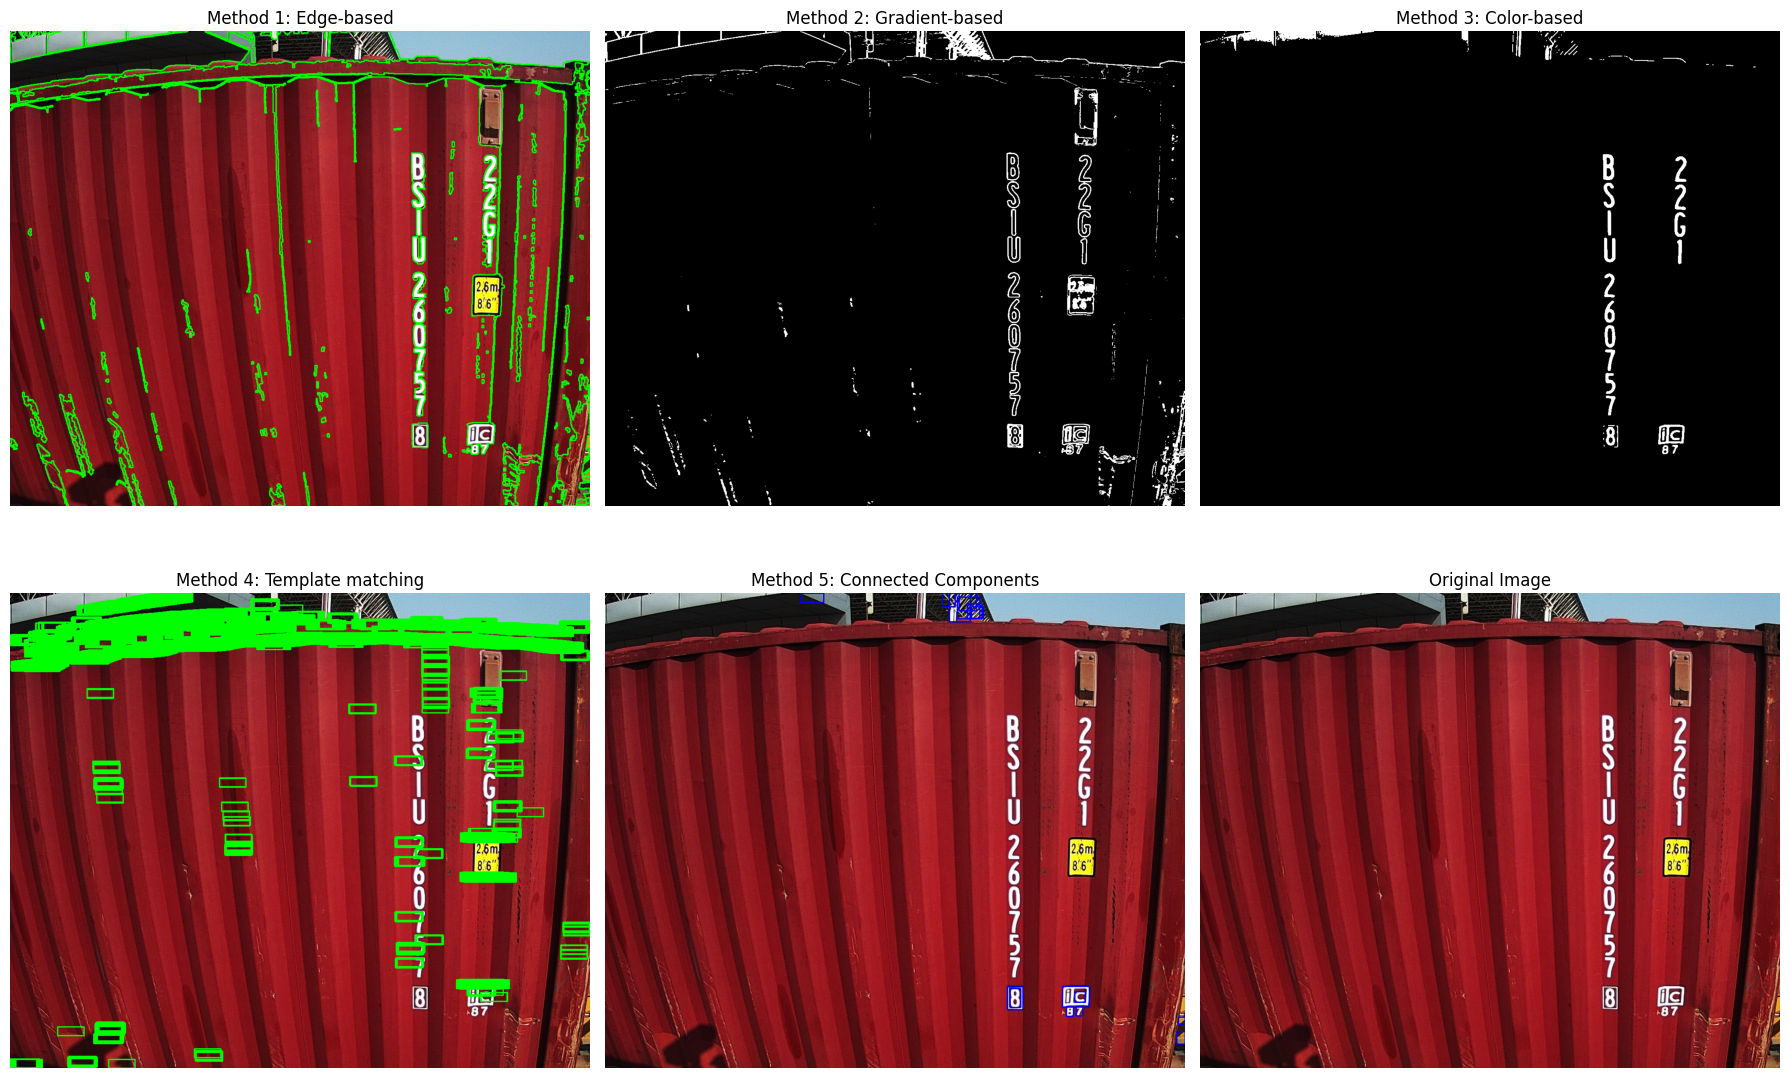

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

class AlternativeDetectionMethods:
    
    def method_1_edge_based(self, image):
        """Edge-based text detection using Canny and morphology"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        # Dilate edges to connect text components
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated = cv2.dilate(edges, kernel, iterations=1)
        
        # Find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        return contours, dilated
    
    def method_2_gradient_based(self, image):
        """Gradient-based approach using Sobel operators"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Calculate gradients
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        magnitude = np.uint8(magnitude / magnitude.max() * 255)
        
        # Threshold to get binary image
        _, binary = cv2.threshold(magnitude, 50, 255, cv2.THRESH_BINARY)
        
        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        return processed
    
    def method_3_color_based(self, image):
        """Color-based segmentation for white text on red background"""
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for white/light colors (text)
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 30, 255])
        
        # Create mask for white regions
        white_mask = cv2.inRange(hsv, lower_white, upper_white)
        
        # Clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel)
        
        return cleaned
    
    def method_4_template_matching(self, image):
        """Template-based approach for specific patterns"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Create simple templates for digit and letter patterns
        # This is a basic approach - you'd need actual templates for better results
        
        # Template for rectangular text regions
        template_rect = np.ones((20, 60), dtype=np.uint8) * 255
        template_rect[5:15, 5:55] = 0  # Create a border pattern
        
        # Match template
        result = cv2.matchTemplate(gray, template_rect, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= 0.3)
        
        return locations, result
    
    def method_5_connected_components(self, image):
        """Connected components analysis"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Threshold
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Connected components analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        # Filter components based on size and aspect ratio
        text_components = []
        for i in range(1, num_labels):  # Skip background (label 0)
            x, y, w, h, area = stats[i]
            aspect_ratio = w / h if h > 0 else 0
            
            # Filter based on text-like properties
            if (100 < area < 2000 and 
                0.5 < aspect_ratio < 5 and 
                w > 10 and h > 8):
                text_components.append((x, y, w, h, area))
        
        return text_components, labels
    
    def compare_methods(self, image_path):
        """Compare all detection methods"""
        image = cv2.imread(image_path)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Method 1: Edge-based
        contours1, edges = self.method_1_edge_based(image)
        result1 = image.copy()
        cv2.drawContours(result1, contours1, -1, (0, 255, 0), 2)
        axes[0, 0].imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Method 1: Edge-based')
        axes[0, 0].axis('off')
        
        # Method 2: Gradient-based
        gradient_result = self.method_2_gradient_based(image)
        axes[0, 1].imshow(gradient_result, cmap='gray')
        axes[0, 1].set_title('Method 2: Gradient-based')
        axes[0, 1].axis('off')
        
        # Method 3: Color-based
        color_result = self.method_3_color_based(image)
        axes[0, 2].imshow(color_result, cmap='gray')
        axes[0, 2].set_title('Method 3: Color-based')
        axes[0, 2].axis('off')
        
        # Method 4: Template matching
        locations, template_result = self.method_4_template_matching(image)
        result4 = image.copy()
        for pt in zip(*locations[::-1]):
            cv2.rectangle(result4, pt, (pt[0] + 60, pt[1] + 20), (0, 255, 0), 2)
        axes[1, 0].imshow(cv2.cvtColor(result4, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('Method 4: Template matching')
        axes[1, 0].axis('off')
        
        # Method 5: Connected components
        components, labels = self.method_5_connected_components(image)
        result5 = image.copy()
        for x, y, w, h, area in components:
            cv2.rectangle(result5, (x, y), (x+w, y+h), (255, 0, 0), 2)
        axes[1, 1].imshow(cv2.cvtColor(result5, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('Method 5: Connected Components')
        axes[1, 1].axis('off')
        
        # Original image
        axes[1, 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title('Original Image')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

# Usage example
def test_alternative_methods():
    detector = AlternativeDetectionMethods()
    
    # Replace with your image path
    image_path = "cropped_container_simple.jpg"
    
    try:
        detector.compare_methods(image_path)
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    test_alternative_methods()

Running hybrid detection...


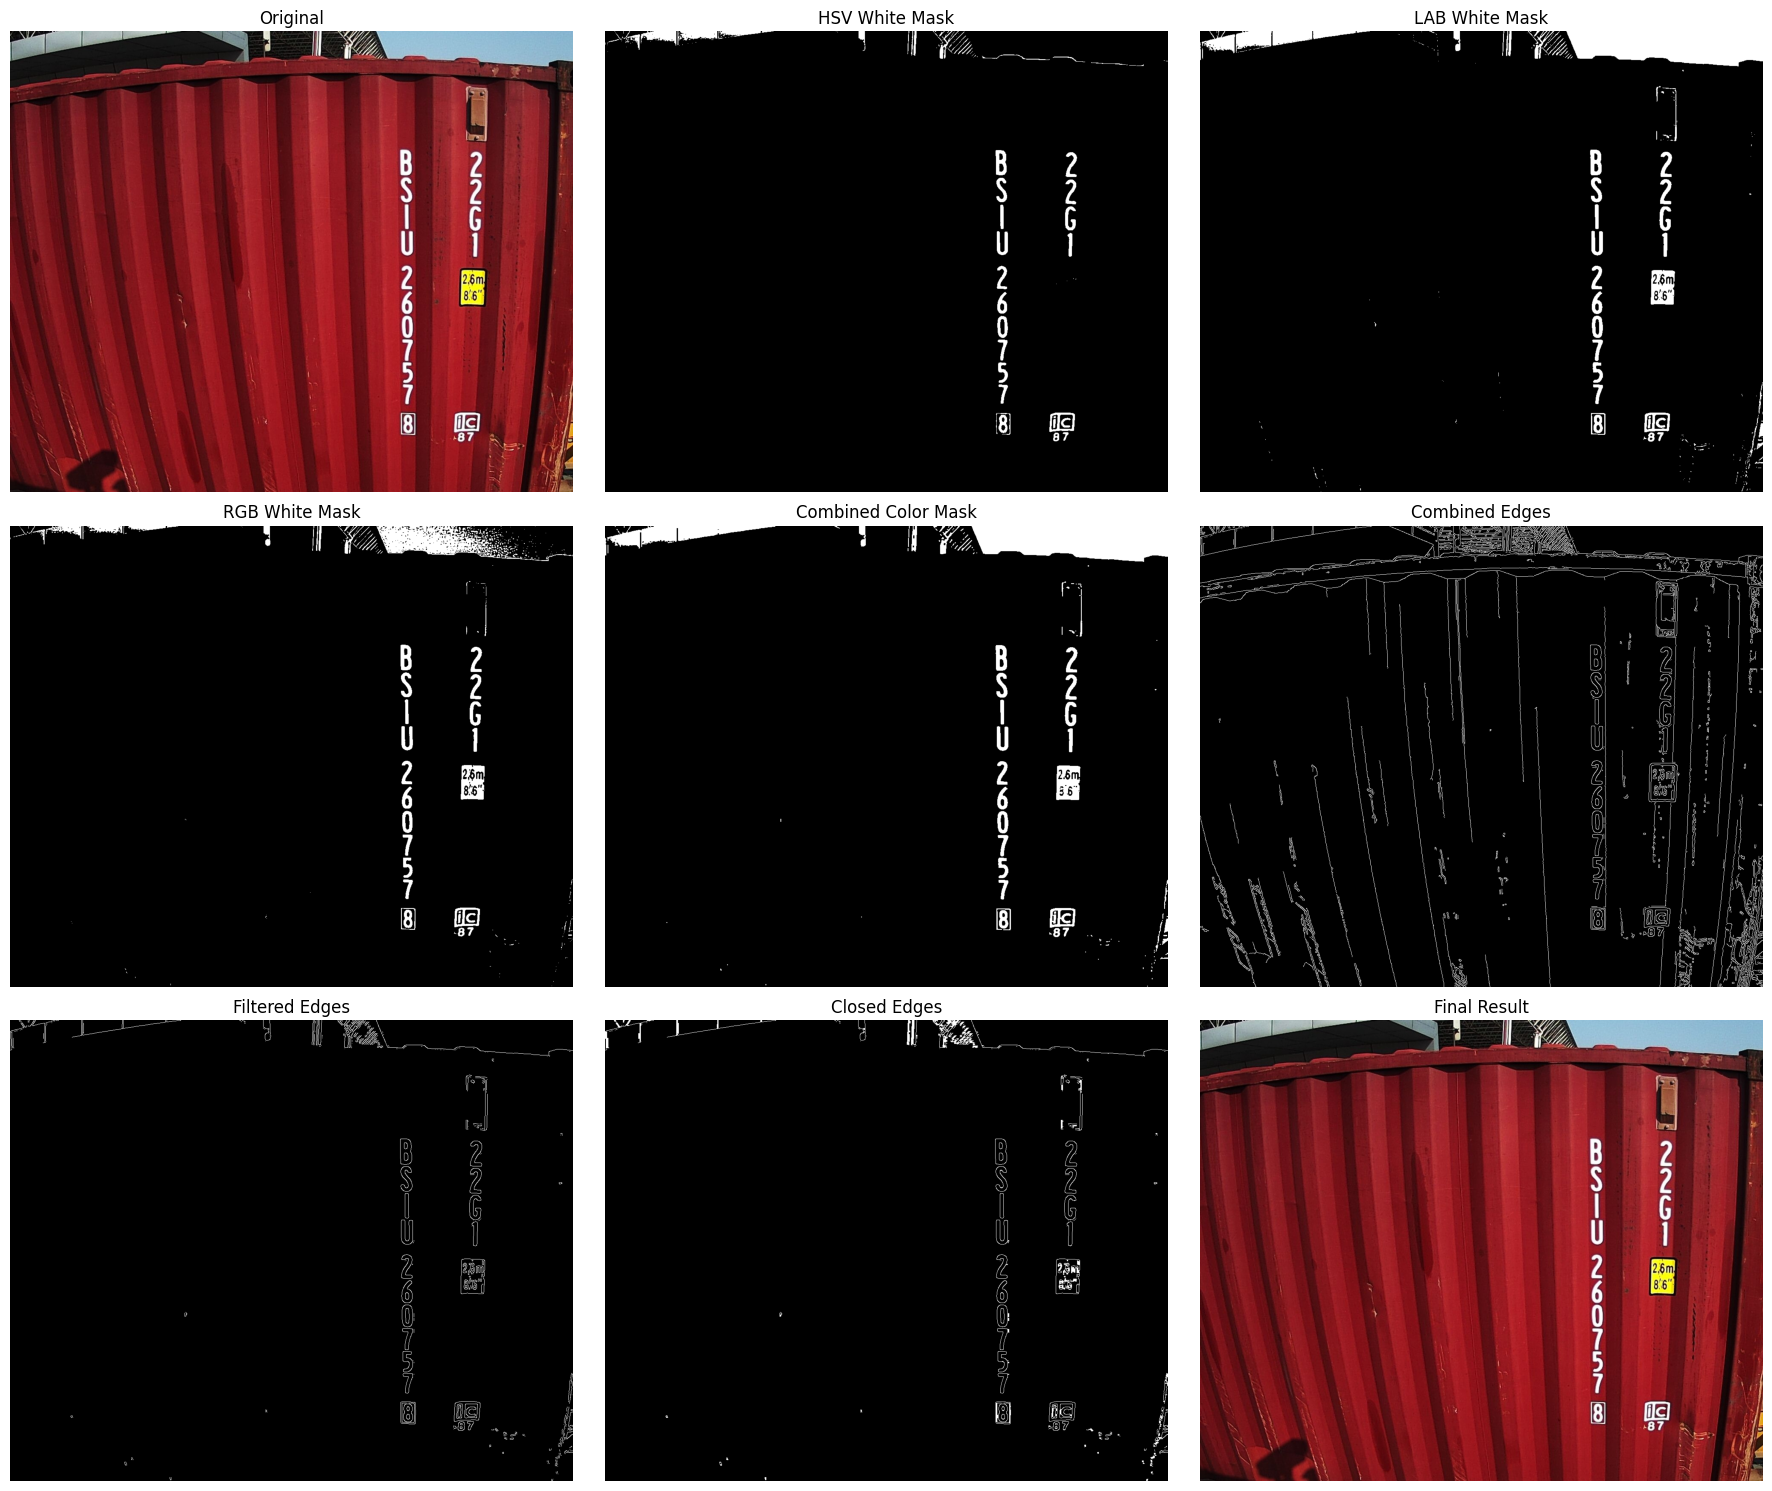

Detected 0 container code regions:
--------------------------------------------------------------------------------

Extracting ROIs for OCR...

Extracted 0 ROIs ready for OCR processing!


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class HybridContainerCodeDetector:
    def __init__(self):
        self.debug_images = {}
    
    def enhanced_color_segmentation(self, image):
        """Improved color-based segmentation with multiple color spaces"""
        # Method 1: HSV-based white detection
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 30, 255])
        white_mask_hsv = cv2.inRange(hsv, lower_white, upper_white)
        
        # Method 2: LAB-based approach (better for lighting variations)
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel = lab[:, :, 0]
        # High L values indicate bright/white regions
        _, white_mask_lab = cv2.threshold(l_channel, 160, 255, cv2.THRESH_BINARY)
        
        # Method 3: RGB-based approach
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, white_mask_rgb = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
        
        # Combine all masks
        combined_mask = cv2.bitwise_or(white_mask_hsv, white_mask_lab)
        combined_mask = cv2.bitwise_or(combined_mask, white_mask_rgb)
        
        # Clean up the mask
        kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_clean)
        
        # Connect nearby text characters
        kernel_connect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        final_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_connect)
        
        self.debug_images['white_mask_hsv'] = white_mask_hsv
        self.debug_images['white_mask_lab'] = white_mask_lab
        self.debug_images['white_mask_rgb'] = white_mask_rgb
        self.debug_images['combined_color_mask'] = final_mask
        
        return final_mask
    
    def smart_edge_detection(self, image, color_mask=None):
        """Edge detection with region-based filtering"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # Multi-scale edge detection
        edges1 = cv2.Canny(blurred, 30, 100)
        edges2 = cv2.Canny(blurred, 50, 150)
        edges3 = cv2.Canny(blurred, 70, 200)
        
        # Combine edges
        combined_edges = cv2.bitwise_or(edges1, edges2)
        combined_edges = cv2.bitwise_or(combined_edges, edges3)
        
        # If we have a color mask, use it to filter edges
        if color_mask is not None:
            # Only keep edges that are near white regions
            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            dilated_mask = cv2.dilate(color_mask, kernel_dilate, iterations=1)
            filtered_edges = cv2.bitwise_and(combined_edges, dilated_mask)
        else:
            filtered_edges = combined_edges
        
        # Morphological operations to connect text components
        kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        closed_edges = cv2.morphologyEx(filtered_edges, cv2.MORPH_CLOSE, kernel_close)
        
        self.debug_images['combined_edges'] = combined_edges
        self.debug_images['filtered_edges'] = filtered_edges
        self.debug_images['closed_edges'] = closed_edges
        
        return closed_edges
    
    def intelligent_region_filtering(self, contours, image_shape, color_mask=None):
        """Advanced filtering based on multiple criteria"""
        height, width = image_shape[:2]
        filtered_regions = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            aspect_ratio = w / h if h > 0 else 0
            
            # Basic size and aspect ratio filtering
            if not (50 < area < 3000 and 0.3 < aspect_ratio < 8):
                continue
            
            # Position filtering - container codes are typically in specific areas
            # Right side of container, upper portion
            if not (x > width * 0.3 and y < height * 0.8):
                continue
            
            # Dimension filtering for text-like regions
            if not (15 < w < 150 and 8 < h < 40):
                continue
            
            # If we have a color mask, check white pixel density
            white_density = 0
            if color_mask is not None:
                roi_mask = color_mask[y:y+h, x:x+w]
                white_pixels = np.sum(roi_mask == 255)
                total_pixels = w * h
                white_density = white_pixels / total_pixels if total_pixels > 0 else 0
                
                # Filter regions with insufficient white content
                if white_density < 0.1:
                    continue
            
            # Calculate solidity (contour area vs bounding rectangle area)
            contour_area = cv2.contourArea(contour)
            solidity = contour_area / area if area > 0 else 0
            
            # Text regions should have reasonable solidity
            if solidity < 0.1 or solidity > 0.9:
                continue
            
            filtered_regions.append({
                'contour': contour,
                'bbox': (x, y, w, h),
                'area': area,
                'aspect_ratio': aspect_ratio,
                'white_density': white_density,
                'solidity': solidity
            })
        
        # Sort by combination of area and white density
        filtered_regions.sort(key=lambda x: (x['area'] * x['white_density']), reverse=True)
        
        return filtered_regions
    
    def detect_container_codes(self, image_path):
        """Main hybrid detection function"""
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        self.debug_images['original'] = image
        
        # Step 1: Color-based segmentation to find white text
        color_mask = self.enhanced_color_segmentation(image)
        
        # Step 2: Smart edge detection using color information
        edge_image = self.smart_edge_detection(image, color_mask)
        
        # Step 3: Find contours from edge image
        contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Step 4: Intelligent filtering
        code_regions = self.intelligent_region_filtering(contours, image.shape, color_mask)
        
        # Step 5: Extract ROI images
        for i, region in enumerate(code_regions):
            x, y, w, h = region['bbox']
            region['roi_original'] = image[y:y+h, x:x+w]
            region['roi_mask'] = color_mask[y:y+h, x:x+w]
        
        return code_regions
    
    def non_maximum_suppression(self, regions, overlap_threshold=0.3):
        """Remove overlapping detections"""
        if len(regions) == 0:
            return []
        
        # Sort by score (area * white_density)
        regions = sorted(regions, key=lambda x: x['area'] * x['white_density'], reverse=True)
        
        keep = []
        while len(regions) > 0:
            current = regions.pop(0)
            keep.append(current)
            
            # Remove overlapping regions
            regions = [r for r in regions if self.calculate_overlap(current['bbox'], r['bbox']) < overlap_threshold]
        
        return keep
    
    def calculate_overlap(self, bbox1, bbox2):
        """Calculate overlap ratio between two bounding boxes"""
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        
        # Calculate intersection
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection = (x_right - x_left) * (y_bottom - y_top)
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0.0
    
    def visualize_results(self, image_path, show_debug=True):
        """Comprehensive visualization"""
        image = cv2.imread(image_path)
        code_regions = self.detect_container_codes(image_path)
        
        # Apply non-maximum suppression
        code_regions = self.non_maximum_suppression(code_regions)
        
        if show_debug:
            # Create visualization
            fig, axes = plt.subplots(3, 3, figsize=(18, 15))
            axes = axes.flatten()
            
            # Show processing steps
            steps = [
                ('Original', 'original'),
                ('HSV White Mask', 'white_mask_hsv'),
                ('LAB White Mask', 'white_mask_lab'),
                ('RGB White Mask', 'white_mask_rgb'),
                ('Combined Color Mask', 'combined_color_mask'),
                ('Combined Edges', 'combined_edges'),
                ('Filtered Edges', 'filtered_edges'),
                ('Closed Edges', 'closed_edges'),
                ('Final Result', 'original')
            ]
            
            for i, (title, key) in enumerate(steps):
                if i < 8:
                    img_to_show = self.debug_images.get(key, np.zeros((100, 100)))
                    if len(img_to_show.shape) == 3:
                        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(img_to_show, cmap='gray' if len(img_to_show.shape) == 2 else None)
                else:
                    # Final result with bounding boxes
                    result_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(result_img)
                    
                    # Draw bounding boxes with scores
                    for j, region in enumerate(code_regions):
                        x, y, w, h = region['bbox']
                        score = region['area'] * region['white_density']
                        
                        rect = Rectangle((x, y), w, h, linewidth=2, 
                                       edgecolor='red', facecolor='none')
                        axes[i].add_patch(rect)
                        axes[i].text(x, y-5, f'R{j+1}({score:.0f})', 
                                   color='red', fontsize=8, weight='bold')
                
                axes[i].set_title(title)
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # Print detailed results
        print(f"Detected {len(code_regions)} container code regions:")
        print("-" * 80)
        for i, region in enumerate(code_regions):
            x, y, w, h = region['bbox']
            print(f"Region {i+1}:")
            print(f"  Position: ({x}, {y})")
            print(f"  Size: {w} x {h}")
            print(f"  Area: {region['area']}")
            print(f"  Aspect Ratio: {region['aspect_ratio']:.2f}")
            print(f"  White Density: {region['white_density']:.2f}")
            print(f"  Solidity: {region['solidity']:.2f}")
            print(f"  Score: {region['area'] * region['white_density']:.0f}")
            print()
        
        return code_regions
    
    def extract_rois_for_ocr(self, image_path, output_dir="output_rois"):
        """Extract and save ROIs for OCR processing"""
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        code_regions = self.detect_container_codes(image_path)
        code_regions = self.non_maximum_suppression(code_regions)
        
        extracted_rois = []
        
        for i, region in enumerate(code_regions):
            # Save original ROI
            roi_original = region['roi_original']
            roi_mask = region['roi_mask']
            
            # Create cleaned ROI using mask
            roi_cleaned = cv2.bitwise_and(roi_original, roi_original, mask=roi_mask)
            
            # Save both versions
            cv2.imwrite(f"{output_dir}/region_{i+1}_original.jpg", roi_original)
            cv2.imwrite(f"{output_dir}/region_{i+1}_mask.jpg", roi_mask)
            cv2.imwrite(f"{output_dir}/region_{i+1}_cleaned.jpg", roi_cleaned)
            
            extracted_rois.append({
                'id': i+1,
                'bbox': region['bbox'],
                'roi_original': roi_original,
                'roi_mask': roi_mask,
                'roi_cleaned': roi_cleaned,
                'score': region['area'] * region['white_density']
            })
            
            print(f"Saved region {i+1} ROIs to {output_dir}/")
        
        return extracted_rois

# Usage example
def main():
    detector = HybridContainerCodeDetector()
    
    # Replace with your image path
    image_path = "cropped_container_simple.jpg"
    try:
        # Visualize detection process
        print("Running hybrid detection...")
        detector.visualize_results(image_path, show_debug=True)
        
        # Extract ROIs for OCR
        print("\nExtracting ROIs for OCR...")
        rois = detector.extract_rois_for_ocr(image_path)
        
        print(f"\nExtracted {len(rois)} ROIs ready for OCR processing!")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

72.68495804398148


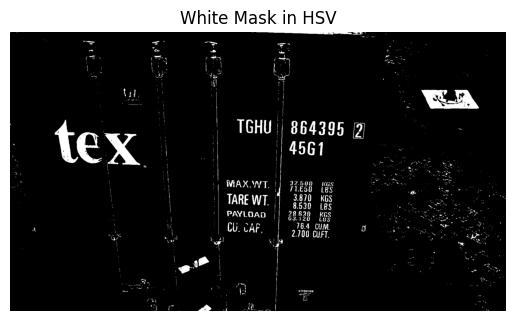

✅ Saved HSV white mask as 'white_mask_hsv.png'


In [58]:
import cv2
import numpy as np

# Load image
image = cv2.imread("images/1-122843001-OCR-AS-B01.jpg")

# Convert to HSV and create white mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Check if the image is mostly white/gray (high mean intensity)
mean_gray = np.mean(gray)
print(mean_gray)
if mean_gray > 120:  # You can adjust this threshold
    print("Image is mostly white/gray, inverting colors...")
    gray = 255 - gray
    image_inv = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(image_inv, cv2.COLOR_BGR2HSV)
    # visualize the mask
    import matplotlib.pyplot as plt
    plt.imshow(image_inv, cmap='gray')
    plt.title('White Mask in HSV')
    plt.axis('off')
    plt.show()


lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 30, 255])
white_mask_hsv = cv2.inRange(hsv, lower_white, upper_white)



for i in range(0):
    kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    white_mask_hsv = cv2.morphologyEx(white_mask_hsv, cv2.MORPH_OPEN, kernel_clean)
    white_mask_hsv = cv2.morphologyEx(white_mask_hsv, cv2.MORPH_CLOSE, kernel_clean)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    white_mask_hsv = cv2.dilate(white_mask_hsv, kernel_dilate, iterations=1)

# visualize the mask
import matplotlib.pyplot as plt
plt.imshow(white_mask_hsv, cmap='gray')
plt.title('White Mask in HSV')
plt.axis('off')
plt.show()

# Save the mask as an image
cv2.imwrite("white_mask_hsv.png", white_mask_hsv)
print("✅ Saved HSV white mask as 'white_mask_hsv.png'")

In [59]:
import cv2
import pytesseract
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# If you're on Windows, you might need to specify the tesseract path
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def detect_text_regions(image_path, output_path=None):
    """
    Detect text regions in an image and draw bounding boxes around them
    
    Args:
        image_path (str): Path to input image
        output_path (str): Optional path to save output image
    
    Returns:
        tuple: (image_with_boxes, text_data)
    """
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert to RGB for pytesseract
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get text detection data from pytesseract
    # image_to_data returns detailed information about detected text
    text_data = pytesseract.image_to_data(rgb_image, output_type=pytesseract.Output.DICT)
    
    # Create a copy of the image for drawing boxes
    image_with_boxes = image.copy()
    
    # Filter and draw bounding boxes
    n_boxes = len(text_data['text'])
    valid_detections = []
    
    for i in range(n_boxes):
        # Filter out empty text and low confidence detections
        confidence = int(text_data['conf'][i])
        text = text_data['text'][i].strip()
        
        if confidence > 30 and len(text) > 0:  # Confidence threshold
            # Get bounding box coordinates
            x = text_data['left'][i]
            y = text_data['top'][i]
            w = text_data['width'][i]
            h = text_data['height'][i]
            
            # Draw rectangle around text
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Optional: Add confidence score as text
            cv2.putText(image_with_boxes, f'{confidence}%', 
                       (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            valid_detections.append({
                'text': text,
                'confidence': confidence,
                'bbox': (x, y, w, h)
            })
    
    # Save output image if path provided
    if output_path:
        cv2.imwrite(output_path, image_with_boxes)
    
    return image_with_boxes, valid_detections

def detect_text_regions_advanced(image_path, output_path=None):
    """
    Advanced text detection with preprocessing for better results
    """
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Preprocessing for better text detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply different preprocessing techniques
    # 1. Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # 2. Adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    
    # 3. Morphological operations to clean up
    kernel = np.ones((2, 2), np.uint8)
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Convert back to RGB for pytesseract
    rgb_processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)
    
    # Get text detection data
    text_data = pytesseract.image_to_data(rgb_processed, output_type=pytesseract.Output.DICT)
    
    # Create output image
    image_with_boxes = image.copy()
    
    # Process detections
    n_boxes = len(text_data['text'])
    valid_detections = []
    
    # Group detections by text blocks for better visualization
    for i in range(n_boxes):
        confidence = int(text_data['conf'][i])
        text = text_data['text'][i].strip()
        
        if confidence > 20 and len(text) > 0:
            x = text_data['left'][i]
            y = text_data['top'][i]
            w = text_data['width'][i]
            h = text_data['height'][i]
            
            # Different colors for different confidence levels
            if confidence > 70:
                color = (0, 255, 0)  # Green for high confidence
            elif confidence > 50:
                color = (0, 255, 255)  # Yellow for medium confidence
            else:
                color = (0, 165, 255)  # Orange for low confidence
            
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
            
            # Add text label
            label = f'{text} ({confidence}%)'
            cv2.putText(image_with_boxes, label, (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            
            valid_detections.append({
                'text': text,
                'confidence': confidence,
                'bbox': (x, y, w, h)
            })
    
    if output_path:
        cv2.imwrite(output_path, image_with_boxes)
    
    return image_with_boxes, valid_detections

def display_results(image_with_boxes, detections):
    """
    Display the results using matplotlib
    """
    # Convert BGR to RGB for matplotlib
    rgb_image = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title(f'Text Detection Results - {len(detections)} regions detected')
    plt.tight_layout()
    plt.show()
    
    # Print detected text
    print(f"\nDetected {len(detections)} text regions:")
    print("-" * 50)
    for i, detection in enumerate(detections, 1):
        print(f"{i}. Text: '{detection['text']}'")
        print(f"   Confidence: {detection['confidence']}%")
        print(f"   Bounding Box: {detection['bbox']}")
        print()

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "white_mask_hsv.png"
    
    try:
        # Method 1: Basic text detection
        print("Running basic text detection...")
        result_image, detections = detect_text_regions(image_path, "output_basic.jpg")
        
        # Method 2: Advanced text detection with preprocessing
        print("Running advanced text detection...")
        result_image_adv, detections_adv = detect_text_regions_advanced(image_path, "output_advanced.jpg")
        
        # Display results
        print(f"Basic method found {len(detections)} text regions")
        print(f"Advanced method found {len(detections_adv)} text regions")
        
        # Display the advanced results
        display_results(result_image_adv, detections_adv)
        
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have installed the required packages:")
        print("pip install opencv-python pytesseract pillow matplotlib")
        print("Also install Tesseract OCR: https://github.com/tesseract-ocr/tesseract")

ModuleNotFoundError: No module named 'pytesseract'

Method 1: Advanced Container Edge Detection
No container detected!
Failed to detect container
Advanced method failed: cannot unpack non-iterable NoneType object
Trying simple method...
Saved cropped container as 'cropped_container_simple.jpg'
Crop region: (1075, 164, 269, 716)


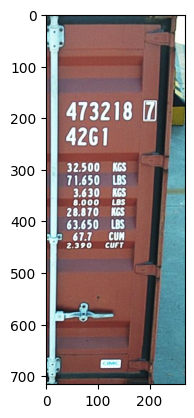

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

class ContainerEdgeDetector:
    def __init__(self):
        self.debug_images = {}
    
    def preprocess_for_edges(self, image):
        """Preprocess image for better edge detection"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply bilateral filter to reduce noise while keeping edges sharp
        filtered = cv2.bilateralFilter(gray, 9, 75, 75)
        
        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(filtered)
        
        self.debug_images['gray'] = gray
        self.debug_images['filtered'] = filtered
        self.debug_images['enhanced'] = enhanced
        
        return enhanced
    
    def detect_container_edges(self, image):
        """Detect container edges using multiple methods"""
        preprocessed = self.preprocess_for_edges(image)
        
        # Method 1: Canny edge detection with multiple thresholds
        edges1 = cv2.Canny(preprocessed, 50, 150, apertureSize=3)
        edges2 = cv2.Canny(preprocessed, 100, 200, apertureSize=3)
        
        # Combine edges
        combined_edges = cv2.bitwise_or(edges1, edges2)
        
        # Method 2: Morphological gradient for thick edges
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        gradient = cv2.morphologyEx(preprocessed, cv2.MORPH_GRADIENT, kernel)
        _, gradient_thresh = cv2.threshold(gradient, 30, 255, cv2.THRESH_BINARY)
        
        # Combine both methods
        final_edges = cv2.bitwise_or(combined_edges, gradient_thresh)
        
        # Clean up edges
        kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned_edges = cv2.morphologyEx(final_edges, cv2.MORPH_CLOSE, kernel_clean)
        
        self.debug_images['edges1'] = edges1
        self.debug_images['edges2'] = edges2
        self.debug_images['combined_edges'] = combined_edges
        self.debug_images['gradient'] = gradient_thresh
        self.debug_images['final_edges'] = cleaned_edges
        
        return cleaned_edges
    
    def find_container_contour(self, edges, original_image):
        """Find the main container contour"""
        height, width = edges.shape
        
        # Find all contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return None
        
        # Filter contours based on container characteristics
        container_candidates = []
        
        for contour in contours:
            # Calculate contour properties
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            
            # Skip very small contours
            if area < 1000:
                continue
            
            # Approximate contour to polygon
            epsilon = 0.02 * perimeter
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            # Container characteristics:
            # 1. Large area (significant portion of image)
            # 2. Rectangular shape (4-8 sides after approximation)
            # 3. Reasonable aspect ratio
            # 4. Not touching image borders too much
            
            area_ratio = area / (width * height)
            aspect_ratio = w / h if h > 0 else 0
            
            # Check if contour is roughly rectangular and large enough
            if (area_ratio > 0.1 and  # At least 10% of image
                4 <= len(approx) <= 8 and  # Roughly rectangular
                0.5 < aspect_ratio < 4 and  # Reasonable aspect ratio
                w > width * 0.3 and h > height * 0.3):  # Minimum size
                
                container_candidates.append({
                    'contour': contour,
                    'approx': approx,
                    'area': area,
                    'bbox': (x, y, w, h),
                    'area_ratio': area_ratio,
                    'aspect_ratio': aspect_ratio
                })
        
        if not container_candidates:
            return None
        
        # Select best candidate (largest area)
        best_candidate = max(container_candidates, key=lambda x: x['area'])
        
        return best_candidate
    
    def refine_container_corners(self, contour, original_image):
        """Refine container corners using corner detection"""
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract ROI around the contour
        margin = 20
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(original_image.shape[1], x + w + margin)
        y2 = min(original_image.shape[0], y + h + margin)
        
        roi = original_image[y1:y2, x1:x2]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # Harris corner detection
        corners = cv2.goodFeaturesToTrack(roi_gray, maxCorners=10, qualityLevel=0.01, minDistance=20)
        
        if corners is not None:
            # Convert corners back to original image coordinates
            corners = corners.reshape(-1, 2)
            corners[:, 0] += x1
            corners[:, 1] += y1
            
            # Find the four corner points of the container
            # This is a simplified approach - you might need more sophisticated corner selection
            container_corners = self.select_container_corners(corners, (x, y, w, h))
        else:
            # Fallback to contour approximation
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            container_corners = approx.reshape(-1, 2)
        
        return container_corners
    
    def select_container_corners(self, corners, bbox):
        """Select the four corners that best represent the container"""
        x, y, w, h = bbox
        
        if len(corners) < 4:
            # Return bounding box corners as fallback
            return np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])
        
        # Find corners closest to each corner of bounding box
        tl = min(corners, key=lambda p: np.linalg.norm(p - [x, y]))
        tr = min(corners, key=lambda p: np.linalg.norm(p - [x+w, y]))
        br = min(corners, key=lambda p: np.linalg.norm(p - [x+w, y+h]))
        bl = min(corners, key=lambda p: np.linalg.norm(p - [x, y+h]))
        
        return np.array([tl, tr, br, bl])
    
    def crop_and_straighten_container(self, image, corners):
        """Crop and straighten the container using perspective transformation"""
        # Order corners: top-left, top-right, bottom-right, bottom-left
        corners = self.order_corners(corners)
        
        # Calculate dimensions of the straightened container
        width_top = np.linalg.norm(corners[1] - corners[0])
        width_bottom = np.linalg.norm(corners[2] - corners[3])
        height_left = np.linalg.norm(corners[3] - corners[0])
        height_right = np.linalg.norm(corners[2] - corners[1])
        
        # Use maximum dimensions
        max_width = int(max(width_top, width_bottom))
        max_height = int(max(height_left, height_right))
        
        # Define destination corners
        dst_corners = np.array([
            [0, 0],
            [max_width, 0],
            [max_width, max_height],
            [0, max_height]
        ], dtype=np.float32)
        
        # Calculate perspective transformation matrix
        src_corners = corners.astype(np.float32)
        transform_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
        
        # Apply perspective transformation
        straightened = cv2.warpPerspective(image, transform_matrix, (max_width, max_height))
        
        self.debug_images['straightened'] = straightened
        
        return straightened, transform_matrix
    
    def order_corners(self, corners):
        """Order corners as top-left, top-right, bottom-right, bottom-left"""
        # Calculate center point
        center = np.mean(corners, axis=0)
        
        # Sort corners by angle from center
        def angle_from_center(point):
            return np.arctan2(point[1] - center[1], point[0] - center[0])
        
        # Sort by angle to get consistent ordering
        sorted_corners = sorted(corners, key=angle_from_center)
        
        # Find top-left corner (minimum sum of coordinates)
        tl_idx = np.argmin([np.sum(corner) for corner in sorted_corners])
        
        # Reorder starting from top-left
        ordered = sorted_corners[tl_idx:] + sorted_corners[:tl_idx]
        
        # Ensure we have the correct order by checking relative positions
        ordered = np.array(ordered)
        
        # Alternative ordering method based on coordinate sums and differences
        sums = np.sum(corners, axis=1)
        diffs = np.diff(corners, axis=1).flatten()
        
        tl = corners[np.argmin(sums)]
        br = corners[np.argmax(sums)]
        tr = corners[np.argmin(diffs)]
        bl = corners[np.argmax(diffs)]
        
        return np.array([tl, tr, br, bl])
    
    def detect_and_crop_container(self, image_path):
        """Main function to detect and crop container"""
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        self.debug_images['original'] = image
        
        # Detect edges
        edges = self.detect_container_edges(image)
        
        # Find container contour
        container_info = self.find_container_contour(edges, image)
        
        if container_info is None:
            print("No container detected!")
            return None, None
        
        # Refine corners
        corners = self.refine_container_corners(container_info['contour'], image)
        
        # Crop and straighten
        cropped_container, transform_matrix = self.crop_and_straighten_container(image, corners)
        
        return cropped_container, {
            'corners': corners,
            'contour': container_info['contour'],
            'bbox': container_info['bbox'],
            'transform_matrix': transform_matrix
        }
    
    def visualize_detection_process(self, image_path):
        """Visualize the entire detection process"""
        image = cv2.imread(image_path)
        cropped_container, detection_info = self.detect_and_crop_container(image_path)
        
        if cropped_container is None:
            print("Failed to detect container")
            return
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        axes = axes.flatten()
        
        # Show processing steps
        steps = [
            ('Original Image', 'original'),
            ('Grayscale', 'gray'),
            ('Filtered', 'filtered'),
            ('Enhanced (CLAHE)', 'enhanced'),
            ('Canny Edges', 'edges1'),
            ('Combined Edges', 'final_edges'),
            ('Container Detection', 'original'),
            ('Corner Points', 'original'),
            ('Cropped & Straightened', 'straightened')
        ]
        
        for i, (title, key) in enumerate(steps):
            if i < 6:
                img_to_show = self.debug_images.get(key, np.zeros((100, 100)))
                if len(img_to_show.shape) == 3:
                    img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img_to_show, cmap='gray' if len(img_to_show.shape) == 2 else None)
            elif i == 6:
                # Show container contour
                result_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                axes[i].imshow(result_img)
                if detection_info:
                    contour = detection_info['contour']
                    # Draw contour
                    contour_image = np.zeros_like(result_img)
                    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 3)
                    axes[i].imshow(contour_image, alpha=0.5)
            elif i == 7:
                # Show corner points
                result_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                axes[i].imshow(result_img)
                if detection_info:
                    corners = detection_info['corners']
                    # Draw corners
                    for j, corner in enumerate(corners):
                        axes[i].plot(corner[0], corner[1], 'ro', markersize=8)
                        axes[i].text(corner[0]+10, corner[1]+10, f'C{j+1}', color='red', fontsize=10)
            else:
                # Show cropped result
                if cropped_container is not None:
                    cropped_rgb = cv2.cvtColor(cropped_container, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(cropped_rgb)
            
            axes[i].set_title(title)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print detection info
        if detection_info:
            print("Container Detection Results:")
            print(f"  Bounding Box: {detection_info['bbox']}")
            print(f"  Corners: {len(detection_info['corners'])} points detected")
            print(f"  Cropped Size: {cropped_container.shape[:2]}")
        
        return cropped_container, detection_info

# Simplified approach for difficult cases
class SimpleContainerCropper:
    def __init__(self):
        pass
    
    def detect_container_color(self, image):
        """Detect container based on dominant color (red in your case)"""
        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for red color (container)
        # Red color has two ranges in HSV
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])
        
        # Create masks
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)
        
        # Clean up mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        cleaned_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
        cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)
        
        return cleaned_mask
    
    def simple_container_crop(self, image_path):
        """Simple cropping based on largest rectangular region"""
        image = cv2.imread(image_path)
        
        # Method 1: Color-based detection
        color_mask = self.detect_container_color(image)
        
        # Find largest contour
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            # Add some padding
            padding = 20
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(image.shape[1] - x, w + 2 * padding)
            h = min(image.shape[0] - y, h + 2 * padding)
            
            cropped = image[y:y+h, x:x+w]
            return cropped, (x, y, w, h)
        
        return None, None

# Usage example
def main():
    # Method 1: Advanced edge detection
    print("Method 1: Advanced Container Edge Detection")
    detector = ContainerEdgeDetector()
    
    image_path = "images/1-150911001-OCR-AS-B01.jpg"  # Replace with your image path
    
    try:
        cropped_container, detection_info = detector.visualize_detection_process(image_path)
        
        if cropped_container is not None:
            # Save the cropped container
            cv2.imwrite("cropped_container_advanced.jpg", cropped_container)
            print("Saved cropped container as 'cropped_container_advanced.jpg'")
        
    except Exception as e:
        print(f"Advanced method failed: {e}")
        print("Trying simple method...")
        
        # Method 2: Simple color-based cropping
        simple_cropper = SimpleContainerCropper()
        cropped_simple, bbox = simple_cropper.simple_container_crop(image_path)
        
        if cropped_simple is not None:
            cv2.imwrite("cropped_container_simple.jpg", cropped_simple)
            print("Saved cropped container as 'cropped_container_simple.jpg'")
            print(f"Crop region: {bbox}")
            #Show the cropped image
            plt.imshow(cv2.cvtColor(cropped_simple, cv2.COLOR_BGR2RGB))
            
        else:
            print("Both methods failed to detect container")

if __name__ == "__main__":
    main()

In [40]:
import cv2
import numpy as np

# Load image
image = cv2.imread('images/1-150911001-OCR-AS-B01.jpg')
orig = image.copy()

# Resize (optional, for speed)
# image = cv2.resize(image, (800, 800))

# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge Detection
edges = cv2.Canny(gray, 150, 150)

# Morphology to close gaps in edges
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

vertical_lines = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)

# Find vertical bar contours
contours, _ = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 0.7 * gray.shape[0] and w < 0.05 * gray.shape[1]:  # Tall and thin
        gray[:, x:x+w] = np.median(gray)


# Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area and aspect ratio
candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = h / float(w)
    area = cv2.contourArea(cnt)
    if area > 50000 and 0.8 < aspect_ratio < 2.0:  # door-like region
        candidates.append((x, y, w, h))

# Select best candidate (largest area)
if candidates:
    candidates = sorted(candidates, key=lambda b: b[2]*b[3], reverse=True)
    x, y, w, h = candidates[0]
    door_crop = orig[y:y+h, x:x+w]
    cv2.imwrite("cropped_door.png", door_crop)
    print("✅ Cropped container door saved as 'cropped_door.png'")
else:
    print("❌ No container door detected.")


❌ No container door detected.


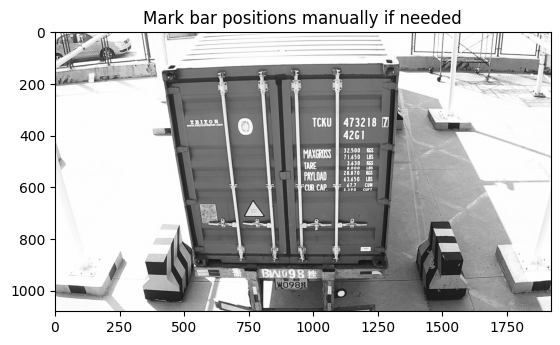

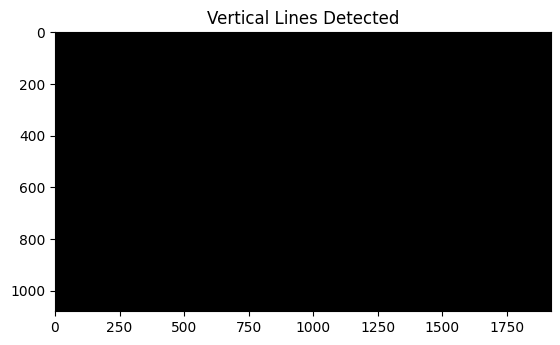

❌ No container door detected.


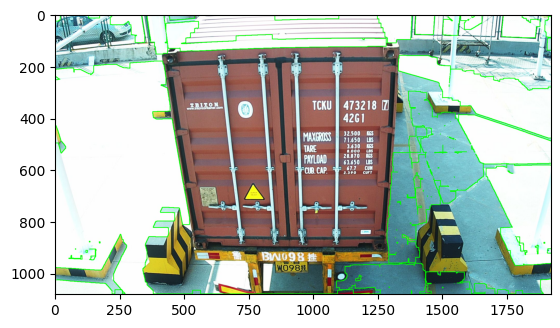

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('images/1-150911001-OCR-AS-B01.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
orig = image.copy()


# Optionally, visualize to find bar positions
plt.imshow(gray, cmap='gray')
plt.title("Mark bar positions manually if needed")
plt.show()

# Continue with edge detection and morphology
edges = cv2.Canny(gray, 150, 150)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

vertical_lines = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)

#visualize vertical lines
plt.imshow(vertical_lines, cmap='gray')
plt.title("Vertical Lines Detected")
plt.show()

# Find vertical bar contours
contours, _ = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 0.7 * gray.shape[0] and w < 0.05 * gray.shape[1]:  # Tall and thin
        gray[:, x:x+w] = np.median(gray)

# Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# visualize contours
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))

# Filter contours by area and aspect ratio
candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = h / float(w)
    area = cv2.contourArea(cnt)
    if area > 50000 and 0.8 < aspect_ratio < 2.0:  # door-like region
        candidates.append((x, y, w, h))

# Select best candidate (largest area)
if candidates:
    candidates = sorted(candidates, key=lambda b: b[2]*b[3], reverse=True)
    x, y, w, h = candidates[0]
    door_crop = orig[y:y+h, x:x+w]
    cv2.imwrite("cropped_door.png", door_crop)
    print("✅ Cropped container door saved as 'cropped_door.png'")
else:
    print("❌ No container door detected.")

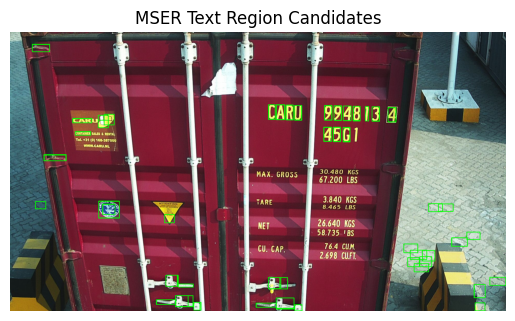

✅ Text region candidates saved as 'mser_text_regions.png'


In [21]:
import cv2
import numpy as np

# Load image
image = cv2.imread('images/1-151528001-OCR-AS-B01.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create MSER detector (without arguments)
mser = cv2.MSER_create()

# Set parameters
mser.setMinArea(550)
mser.setMaxArea(1100)

# Detect regions
regions, _ = mser.detectRegions(gray)

# Draw convex hulls
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

# Draw bounding boxes
vis = image.copy()
for hull in hulls:
    x, y, w, h = cv2.boundingRect(hull)
    if w > 10 and h > 10 and h/w < 5:  # Optional filters
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
# Visualize results
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("MSER Text Region Candidates")
plt.axis('off')
plt.show()
# Save the visualization
cv2.imwrite("mser_text_regions.png", vis)
print("✅ Text region candidates saved as 'mser_text_regions.png'")
